## Project Graham (Part 1: Setup)

In [ ]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import utils
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

### Electrophysiology / Data Structure Background

Data has already been curated through kilosort, which the model will train on to limit complexity.


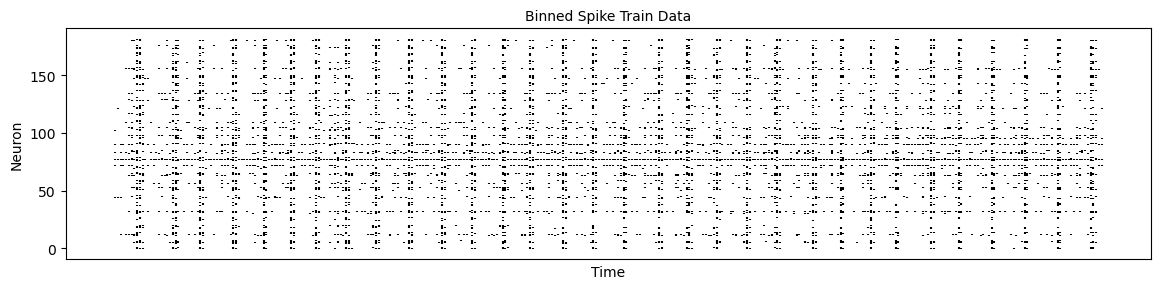

In [83]:
'''
Load in the curated EPhys Data as npz object 
  Data Structure:
    train: 
        Format: {neuron, [associated spike times]}
        Explanation: For each neuron, there is an associated list of spike times
    neuron_data: 
        Format: {neuron, [associated data]}
        Explanation: For each neuron, list of associated data (spatial coordinates, etc.)
    redundant_pairs: literally that
        Format: {neuron, [associated redundant pairs]}
        Explanation: For each neuron, list of associated redundant
    fs: sampling rate
        Format: int
        Explanation: Sampling rate of the data
'''

def convert_to_binned(spike_data, sample_freq, bin_size_ms=500):
    ''' Necessary because raw spike data is too large to be used in training '''
    
    # Number of neurons
    num_neurons = len(spike_data)

    # Calculate total time in seconds based on the maximum spike time across all neurons
    max_spike_time = max(max(times) for times in spike_data.values()) if spike_data else 0
    total_time_seconds = max_spike_time / sample_freq

    # Compute the number of bins
    total_time_ms = total_time_seconds * 1000  # Convert seconds to milliseconds
    num_bins = int(np.ceil(total_time_ms / bin_size_ms))

    # Create/Fill the binned data
    binned_data = np.zeros((num_bins, num_neurons), dtype=int)
    for neuron_idx, (neuron, times) in enumerate(spike_data.items()):
        times_seconds = np.array(times) / sample_freq
        times_ms = times_seconds * 1000
        bin_indices = (times_ms / bin_size_ms).astype(int)
        valid_indices = (bin_indices >= 0) & (bin_indices < num_bins)
        np.add.at(binned_data[:, neuron_idx], bin_indices[valid_indices], 1)

    return binned_data

# Load data
fname = "data.npz"  # Your data file
data = np.load(fname, allow_pickle=True)
spike_train = data['train'].item()
sample_freq = data['fs']

binned_data = convert_to_binned(spike_train, sample_freq)

# Plot binned data
plt.figure(figsize=(14, 3))
plt.title("Binned Spike Train Data", fontsize=10)
plt.xticks([])
plt.ylabel("Neuron")
plt.xlabel("Time")
y = 0
for i in range(binned_data.shape[1]):
    plt.eventplot(np.where(binned_data[:, i] > 0), lineoffsets=y, linelengths=0.5, colors='black')  
    y += 1
plt.show()

### That's cool and all, but how do we quantify characteristics of the data?

* Note that the time axis is messed up from binning, and the number of spikes/unit time is not 
	accurate because of binning as well.

Spike Timing:
	- ISI Distribution
Firing Rates:
		- Mean firing rates
		- Stochasticity quantification
Population Dynamics:
		* Raster plot
Oscillatory Dynamics:
		- Phase locking
		- Rayleigh test for assessing theta/gamma phase dist.

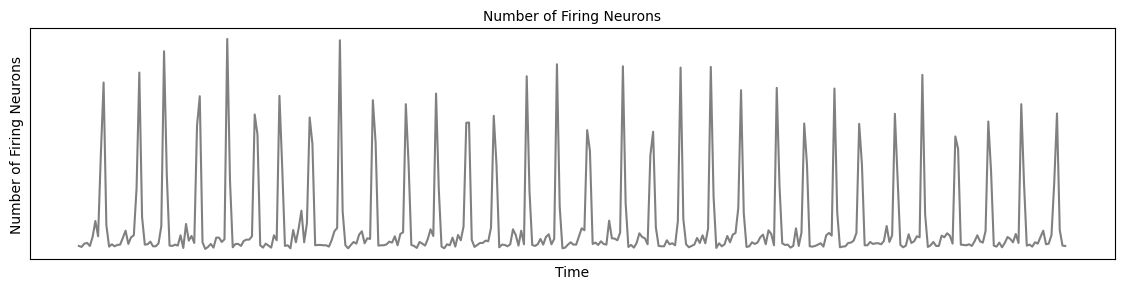

In [78]:
# Get total number of firing neurons at each time step
num_firing_neurons = np.sum(binned_data, axis=1)
num_nuerons = binned_data.shape[1]

# Normalize num_nuerons to original number of neurons
num_firing_neurons = num_firing_neurons / num_nuerons

# Plot number of firing neurons
plt.figure(figsize=(14, 3))
plt.title("Number of Firing Neurons", fontsize=10)
plt.plot(num_firing_neurons, color='grey')
plt.xticks([])
plt.yticks([])
plt.ylabel("Number of Firing Neurons")
plt.xlabel("Time")
plt.show()


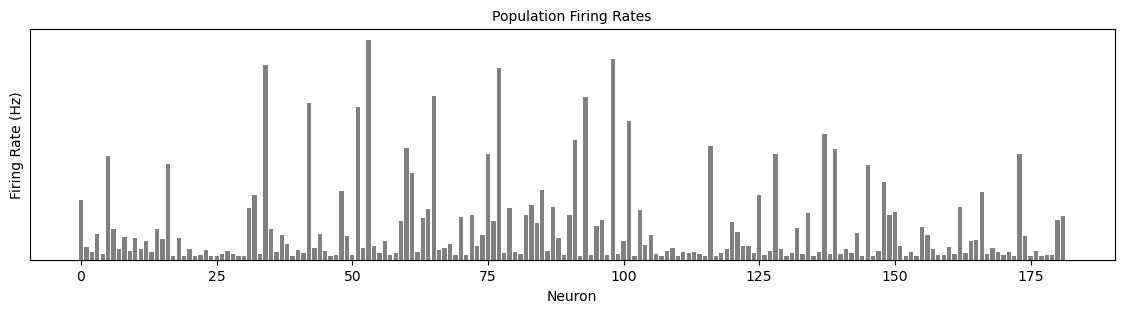

In [82]:
# Population Firing Rates
pop_firing_rates = np.sum(binned_data, axis=0) / (binned_data.shape[0] / 1000)  # Convert to Hz

# Plot population firing rates
plt.figure(figsize=(14, 3))
plt.title("Population Firing Rates", fontsize=10)
plt.xlabel("Neuron")
plt.yticks([])
plt.ylabel("Firing Rate (Hz)")
plt.bar(np.arange(len(pop_firing_rates)), pop_firing_rates, color='grey')
plt.show()


### Neat. Now that we have an idea of what the data is, and how we can analyze it, let's get started with the Spiking Neuron Model    


In [ ]:
# Defining the Network

class SpikingGenerator(nn.Module):
    def __init__(self, num_neurons, num_hidden, Beta=.9):
        super().__init__()

        # Params
        self.num_neurons = num_neurons
        self.num_hidden = num_hidden

        # Fully Conn, LIF layers, Recurrent conn
        self.fc1 = nn.Linear(num_neurons, num_hidden)
        self.lif1 = snn.Leaky(beta=Beta)
        self.fc_r = nn.Linear(num_hidden, num_neurons)

    def forward(self, data, num_steps):

        spike_recording = []
        utils.reset_net(self)

        for step in range(num_steps):
            spike_out, membrane = self(data[step])
            spike_recording.append(spike_out)

        return torch.stack(spike_recording)

SnnModel = SpikingGenerator(num_neurons=100, num_hidden=200)
optimizer = torch.optim.Adam(SnnModel.parameters(), lr=1e-3)



